In [120]:
import math
import numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sys
import joblib
import warnings

In [121]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as Sfs
from sklearn.feature_selection import chi2
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import plotly.express as px

In [122]:
sns.set()

# Data Import and overview

In [123]:
DATASET_PATH = "../../data/tweets_2020_2021.csv"
df = pd.read_csv(filepath_or_buffer=DATASET_PATH, sep=",")
df = df.sort_values(by='timestamp', ascending=True)
df.tail()

,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,topics_ids,topics,sentiment,popularity,followers,following,tweet_count,verified,created_at
612261,612261,612261,1477036834261770241,…. them crawfish was so good yall lmfao,2021-12-31 21:59:57+00:00,795707439219884037,0,0,0,0,1826,NaN,NaN,Positive,0,1826,636,33601,False,2016-11-07 19:20:12+00:00
98252,98252,98252,1477036835603836932,Damn all the freaks are at the New Bev right n...,2021-12-31 21:59:58+00:00,34679503,26,0,0,0,10636,NaN,NaN,Neutral,0,10636,2320,24943,False,2009-04-23 17:58:25+00:00
1072384,1072384,1072384,1477036838217035777,Fast And Professional Vehicle Lockout Service ...,2021-12-31 21:59:58+00:00,210241982,0,0,0,0,394,NaN,NaN,Negative,0,394,465,21897,False,2010-10-30 23:06:33+00:00
1072385,1072385,1072385,1477036840024567809,Very much this https://t.co/b3bgtstLfr,2021-12-31 21:59:59+00:00,883576549,3,0,0,0,702,NaN,NaN,Neutral,0,702,1263,20166,False,2012-10-16 03:01:52+00:00
1072386,1072386,1072386,1477036841933185025,Best thread ever https://t.co/EBo4JkTCx4,2021-12-31 21:59:59+00:00,131371694,0,0,0,0,57,NaN,NaN,Positive,0,57,214,1037,False,2010-04-10 02:33:03+00:00


In [124]:
df.head(10)

,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,topics_ids,topics,sentiment,popularity,followers,following,tweet_count,verified,created_at
0,0,0,1212176422770544641,2️⃣0️⃣1️⃣9️⃣ WHAT. A. YEAR. 🌟 #bestnine2019 #t...,2020-01-01 00:59:14,29885607,35,1,0,0,7545,NaN,NaN,Neutral,1,7545,3335,11473,False,2009-04-09 01:39:24
1,1,1,1212176421659062274,Gold N Hot 🤪 https://t.co/VeO2k4Mq4h,2020-01-01 00:59:14,1130217871286636545,0,0,0,0,4008,NaN,NaN,Neutral,0,4008,1488,141802,False,2019-05-19 21:05:13+00:00
44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,0,0,2220,119.0,Holiday,Positive,0,2220,1523,12883,False,2016-05-27 00:29:50+00:00
46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,0,1,384,46.0,Brand Category,Negative,0,384,651,3615,False,2017-04-27 05:13:14
35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,7,2,13837,10.0,Person,Negative,1,653,732,33826,False,2015-08-21 04:17:25+00:00
41,41,41,1212176426088181760,Disgruntled Pope Francis pulls himself free fr...,2020-01-01 00:59:15,858762062,0,0,0,0,26108,10.0,Person,Positive,0,26108,20584,83121,False,2012-10-02 21:45:01
39,39,39,1212176425916280833,Got my hot coco bc it cold out siiiiide boii h...,2020-01-01 00:59:15,18707915,1,0,0,1,247,NaN,NaN,Neutral,0,247,1425,37954,False,2009-01-07 03:03:04
47,47,47,1212176428017557504,ACC Network missed some solid TV (I assume) by...,2020-01-01 00:59:16,26379236,0,0,0,0,272,NaN,NaN,Negative,0,272,1253,4645,False,2009-03-25 00:46:39
48,48,48,1212176427149414405,UPDATE: Mission Accomplished,2020-01-01 00:59:16,1011249158,1,0,1,0,1803,NaN,NaN,Positive,1,1803,802,52777,False,2012-12-14 14:24:31+00:00
52,52,52,1212176427845607426,My NASA engineer sister..... I would tell you ...,2020-01-01 00:59:16,1057480999943032832,11,0,0,0,1120,46.0,Brand Category,Positive,0,1120,1273,9458,False,2018-10-31 03:54:52


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1072387 entries, 0 to 1072386
Data columns (total 20 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1072387 non-null  int64  
 1   index          1072387 non-null  int64  
 2   tweet_id       1072387 non-null  int64  
 3   text           1072387 non-null  object 
 4   timestamp      1072387 non-null  object 
 5   user_id        1072387 non-null  int64  
 6   like_count     1072387 non-null  int64  
 7   retweet_count  1072387 non-null  int64  
 8   quote_count    1072387 non-null  int64  
 9   reply_count    1072387 non-null  int64  
 10  reach          1072387 non-null  int64  
 11  topics_ids     366686 non-null   float64
 12  topics         366686 non-null   object 
 13  sentiment      1072387 non-null  object 
 14  popularity     1072387 non-null  int64  
 15  followers      1072387 non-null  int64  
 16  following      1072387 non-null  int64  
 17  tweet_co

### Remove Nan values

In [126]:
df.isna().sum()

Unnamed: 0            0
index                 0
tweet_id              0
text                  0
timestamp             0
user_id               0
like_count            0
retweet_count         0
quote_count           0
reply_count           0
reach                 0
topics_ids       705701
topics           705701
sentiment             0
popularity            0
followers             0
following             0
tweet_count           0
verified              0
created_at            0
dtype: int64

In [127]:
df['created_at'].isna().sum()
df = df[df['created_at'].notna()]

## Data Wrangling

Nesta etapa as seguintes tarefas vão ser realizadas:
- Renomear algumas colunas para melhor compreensão dos dados
- Converter nomenclaturas/abreviações para melhor processamento de dados
- Criar novas colunas de categorias para agrupar os diferentes individuos, segundo, fatores de risco

### Variables categorization

In [128]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

#### Categorize by year, month, week days and phases of the day

In [129]:
def get_day_phase(hour):
    if 0 <= hour < 7:
        return "Dawn"
    elif 7 <= hour < 13:
        return "Morning"
    elif 13 <= hour < 16:
        return "Afternoon"
    elif 16 <= hour < 20:
        return "Evening"
    elif 20 <= hour < 24:
        return "Night"

In [130]:
df['year'] = df['timestamp'].apply(lambda x: x.year)
df['month'] = df['timestamp'].apply(lambda x: x.strftime('%B'))
df['day_of_week'] = df['timestamp'].apply(lambda x: x.strftime('%A'))
df['day_phase'] = df['timestamp'].apply(lambda x: get_day_phase(int(x.hour)))
df['week_idx'] = df['timestamp'].apply(lambda x: '%s-%s' % (x.year, '{:02d}'.format(x.isocalendar()[1])))
df

,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,...,followers,following,tweet_count,verified,created_at,year,month,day_of_week,day_phase,week_idx
0,0,0,1212176422770544641,2️⃣0️⃣1️⃣9️⃣ WHAT. A. YEAR. 🌟 #bestnine2019 #t...,2020-01-01 00:59:14,29885607,35,1,0,0,...,7545,3335,11473,False,2009-04-09 01:39:24,2020,January,Wednesday,Dawn,2020-01
1,1,1,1212176421659062274,Gold N Hot 🤪 https://t.co/VeO2k4Mq4h,2020-01-01 00:59:14,1130217871286636545,0,0,0,0,...,4008,1488,141802,False,2019-05-19 21:05:13+00:00,2020,January,Wednesday,Dawn,2020-01
44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,0,0,...,2220,1523,12883,False,2016-05-27 00:29:50+00:00,2020,January,Wednesday,Dawn,2020-01
46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,0,1,...,384,651,3615,False,2017-04-27 05:13:14,2020,January,Wednesday,Dawn,2020-01
35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,7,2,...,653,732,33826,False,2015-08-21 04:17:25+00:00,2020,January,Wednesday,Dawn,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612261,612261,612261,1477036834261770241,…. them crawfish was so good yall lmfao,2021-12-31 21:59:57+00:00,795707439219884037,0,0,0,0,...,1826,636,33601,False,2016-11-07 19:20:12+00:00,2021,December,Friday,Night,2021-52
98252,98252,98252,1477036835603836932,Damn all the freaks are at the New Bev right n...,2021-12-31 21:59:58+00:00,34679503,26,0,0,0,...,10636,2320,24943,False,2009-04-23 17:58:25+00:00,2021,December,Friday,Night,2021-52
1072384,1072384,1072384,1477036838217035777,Fast And Professional Vehicle Lockout Service ...,2021-12-31 21:59:58+00:00,210241982,0,0,0,0,...,394,465,21897,False,2010-10-30 23:06:33+00:00,2021,December,Friday,Night,2021-52
1072385,1072385,1072385,1477036840024567809,Very much this https://t.co/b3bgtstLfr,2021-12-31 21:59:59+00:00,883576549,3,0,0,0,...,702,1263,20166,False,2012-10-16 03:01:52+00:00,2021,December,Friday,Night,2021-52


In [131]:

cols_to_transform = ['day_phase', 'day_of_week', 'month', 'year', 'sentiment', 'verified']

for col in cols_to_transform:
    enc = LabelEncoder()
    enc.fit(df[col])
    df[col + '_enc'] = enc.transform(df[col])

# Day phase: Dawn -> 1 | Morning -> 3 | Afternoon -> 0 | Evening -> 2 | Night -> 4

# Days of the week:
#   Monday -> 1 | Tuesday -> 5 | Wednesday -> 6
#   Thursday -> 4 | Friday -> 0 | Saturday -> 2 | Sunday -> 3

# Months
#   January -> 4 | February -> 3 | March -> 7 | April -> 0
#   May -> 8 | June -> 6 | July -> 5 | August -> 1
#   September -> 11 | October -> 10 | November -> 9 | December -> 2

# Years
#   2020 -> 0 | 2021 -> 1

# Sentiment
#  Negative -> 0 | Neutral -> 1 | Positive -> 2

# Verified
#  False -> 0 | True -> 1

df.head(5)

,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,...,month,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc
0,0,0,1212176422770544641,2️⃣0️⃣1️⃣9️⃣ WHAT. A. YEAR. 🌟 #bestnine2019 #t...,2020-01-01 00:59:14,29885607,35,1,0,0,...,January,Wednesday,Dawn,2020-01,1,6,4,0,1,0
1,1,1,1212176421659062274,Gold N Hot 🤪 https://t.co/VeO2k4Mq4h,2020-01-01 00:59:14,1130217871286636545,0,0,0,0,...,January,Wednesday,Dawn,2020-01,1,6,4,0,1,0
44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,0,0,...,January,Wednesday,Dawn,2020-01,1,6,4,0,2,0
46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,0,1,...,January,Wednesday,Dawn,2020-01,1,6,4,0,0,0
35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,7,2,...,January,Wednesday,Dawn,2020-01,1,6,4,0,0,0


In [132]:
df['created_at'] = pd.to_datetime(df['created_at'], utc=True).dt.strftime("%Y-%m-%d")
df['created_at'] = pd.to_datetime(df['created_at'])
df['seniority'] = df['created_at'].apply(lambda x: relativedelta(datetime.datetime.now(), x).years)
df.head(5)

,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,0,1212176422770544641,2️⃣0️⃣1️⃣9️⃣ WHAT. A. YEAR. 🌟 #bestnine2019 #t...,2020-01-01 00:59:14,29885607,35,1,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,13
1,1,1,1212176421659062274,Gold N Hot 🤪 https://t.co/VeO2k4Mq4h,2020-01-01 00:59:14,1130217871286636545,0,0,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,2
44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,5
46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,0,1,...,Wednesday,Dawn,2020-01,1,6,4,0,0,0,4
35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,7,2,...,Wednesday,Dawn,2020-01,1,6,4,0,0,0,6


In [133]:
df['topics_ids'].fillna(value=0, inplace=True)
df['topics_ids'] = df['topics_ids'].apply(lambda x: int(x))
df['topics'].fillna(value="", inplace=True)
df.head(5)

,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,0,1212176422770544641,2️⃣0️⃣1️⃣9️⃣ WHAT. A. YEAR. 🌟 #bestnine2019 #t...,2020-01-01 00:59:14,29885607,35,1,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,13
1,1,1,1212176421659062274,Gold N Hot 🤪 https://t.co/VeO2k4Mq4h,2020-01-01 00:59:14,1130217871286636545,0,0,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,2
44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,5
46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,0,1,...,Wednesday,Dawn,2020-01,1,6,4,0,0,0,4
35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,7,2,...,Wednesday,Dawn,2020-01,1,6,4,0,0,0,6


In [134]:
vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'topics_ids', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'popularity', 'followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
tweet_vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc']
users_vars = ['followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
num_vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'followers', 'following', 'tweet_count', 'seniority']
cat_vars = ['sentiment_enc', 'verified_enc', 'day_of_week_enc', 'day_phase_enc', 'month_enc']

## Spliting the data by year

In [135]:
df_2020 = df[df['year'] == 2020]
df_2021 = df[df['year'] == 2021]

In [136]:
df_2020.shape

(534942, 32)

In [137]:
df_2021.shape

(537445, 32)

# EDA

- Understanding the behavior of tweets popularity througth different time periods
- Data visualization
- Outliers

## Tweets performance in 2020

In [256]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_phases = ['Dawn', 'Morning', 'Afternoon', 'Evening', 'Night']

In [257]:
tweet_analysis_2020 = df_2020[['day_phase', 'day_of_week', 'month', 'retweet_count', 'quote_count', 'like_count', 'topics', 'sentiment']]

In [262]:
tweet_analysis_2020_ret_day_phase = tweet_analysis_2020.groupby(['day_phase']).agg(
                                                            day_phase_count=pd.NamedAgg(column="day_phase", aggfunc="count"),
                                                            retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
                                                            likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).reindex(day_phases).reset_index()
tweet_analysis_2020_ret_day_phase

,day_phase,day_phase_count,retweet_count,likes_count
0,Dawn,107079,1.606730,9.293316
1,Morning,106274,0.707925,4.485763
2,Afternoon,107278,1.811275,10.877971
3,Evening,107116,1.327561,7.871532
4,Night,107195,2.196520,11.831121


### Retweet count per phase of the day

In [263]:
def analysis_chart(analysis, col_name, x_bar, y_bar, fig_size_width, chart_title):
    ax1 = sns.set_style(style='white', rc=None)
    fig, ax1 = plt.subplots(figsize=(fig_size_width, 10))
    sns.barplot(data=analysis, x=x_bar, y=y_bar, ax=ax1, color='#B33951')
    ax2 = ax1.twinx()
    sns.lineplot(data=analysis[col_name], marker='o', sort=False, ax=ax2)
    plt.title(chart_title)

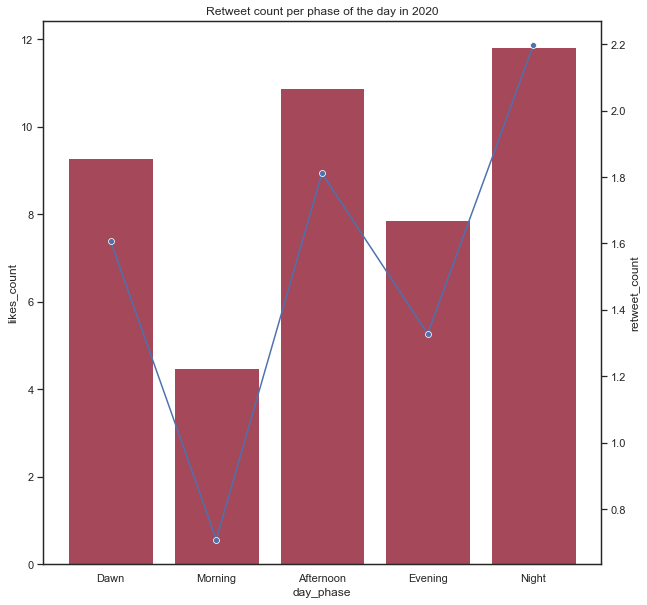

In [269]:
analysis_chart(tweet_analysis_2020_ret_day_phase, 'retweet_count', 'day_phase', 'likes_count', 10, 'Retweet count per phase of the day in 2020')

### Retweet count per day of the week

In [265]:
tweet_analysis_2020_ret_week_day = tweet_analysis_2020.groupby(['day_of_week']).agg(
    day_of_week_count=pd.NamedAgg(column="day_of_week", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).reindex(week_days).reset_index()
tweet_analysis_2020_ret_week_day

,day_of_week,day_of_week_count,retweet_count,likes_count
0,Monday,75963,1.004937,6.542001
1,Tuesday,75952,2.716518,15.230948
2,Wednesday,77453,1.391205,7.909920
3,Thursday,77487,1.366229,7.836476
4,Friday,76047,1.536813,8.340303
5,Saturday,76020,0.964588,6.959958
6,Sunday,76020,1.746527,9.381952


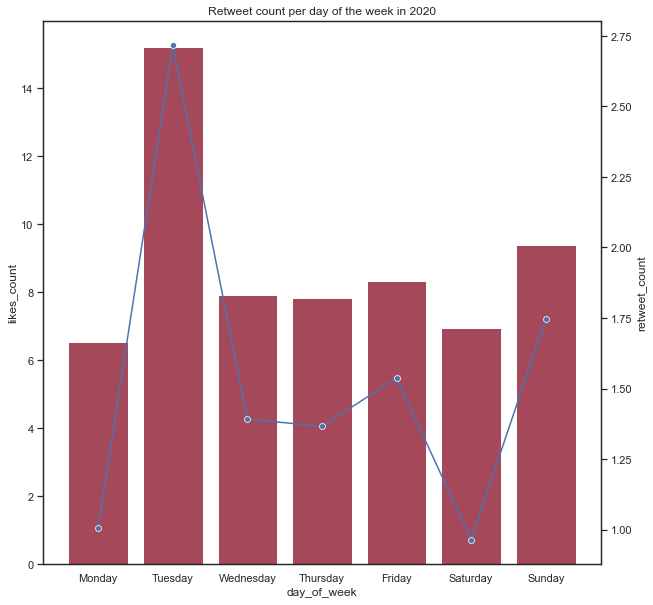

In [270]:
analysis_chart(tweet_analysis_2020_ret_week_day, 'retweet_count', 'day_of_week', 'likes_count', 10, 'Retweet count per day of the week in 2020')

### Retweet count per month

In [267]:
tweet_analysis_2020_ret_month = tweet_analysis_2020.groupby(['month']).agg(
    month_count=pd.NamedAgg(column="month", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).reindex(months).reset_index()
tweet_analysis_2020_ret_month

,month,month_count,retweet_count,likes_count
0,January,45441,1.506987,9.033978
1,February,42575,1.248456,7.909853
2,March,45494,1.664175,8.914648
3,April,44009,0.989525,6.369197
4,May,45376,3.477521,17.771024
5,June,43815,1.640511,10.182586
6,July,45297,1.381438,8.629622
7,August,45165,1.801306,9.342743
8,September,43789,2.003334,9.575647
9,October,45245,1.322400,6.925472


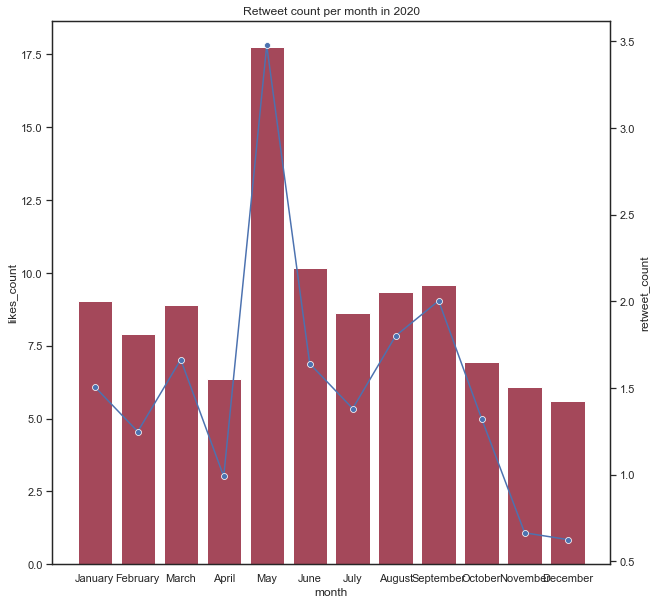

In [271]:
analysis_chart(tweet_analysis_2020_ret_month, 'retweet_count', 'month', 'likes_count', 10, 'Retweet count per month in 2020')

### Tweets performance by sentiment

In [272]:
tweet_analysis_2020_sentiment = tweet_analysis_2020.groupby(['sentiment']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=False).reset_index()
tweet_analysis_2020_sentiment

,sentiment,retweet_count,likes_count
0,Positive,1.904225,10.844869
1,Neutral,1.312302,8.084429
2,Negative,1.142161,6.371969


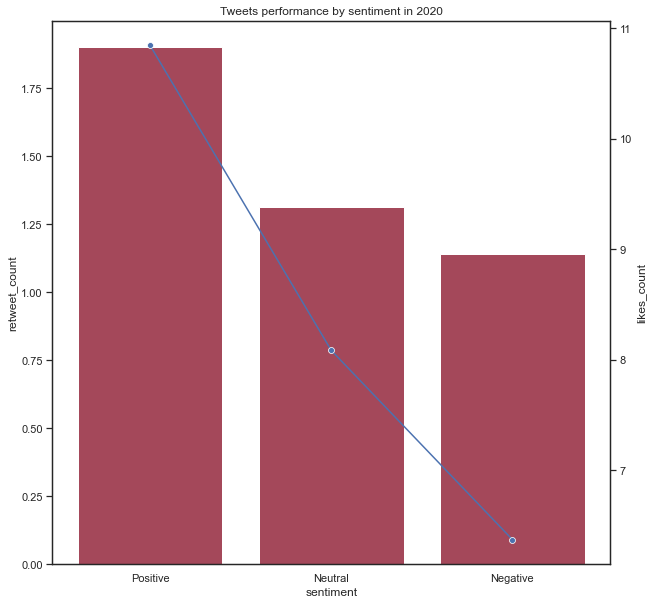

In [273]:
analysis_chart(tweet_analysis_2020_sentiment, 'likes_count', 'sentiment', 'retweet_count', 10, 'Tweets performance by sentiment in 2020')

### Tweets performance by topics

In [149]:
topic_analysis_2020 = tweet_analysis_2020[tweet_analysis_2020['topics'] != ''].copy()

In [150]:
topic_analysis_2020['topics'].value_counts()

Person                            48349
TV Shows                          26347
Interests and Hobbies Vertical    25535
Entities [Entity Service]         20430
Ongoing News Story                15018
Brand Vertical                    14578
Brand Category                    12783
Holiday                            5267
Sports Event                       2787
Brand                              2671
Sport                              2641
Political Body                     1795
Interests and Hobbies Category     1773
Video Game                         1766
Music Genre                        1761
Multimedia Franchise               1680
Sports Team                        1184
Interests and Hobbies              1135
Movie                               884
Video Game Hardware                 645
Book Genre                          373
Movie Genre                         307
Award Show                          209
Musician                            191
Athlete                             138


In [151]:
def group_topics(topic):
    if 'Brand' in topic or 'Product' in topic:
        return 'Brand'
    elif 'Person' in topic:
        return 'Person'
    elif 'Sport' in topic or 'Athlete' in topic or 'Coach' in topic or 'Hockey' in topic or 'Football' in topic or 'NFL' in topic:
        return 'Sport'
    elif 'TV' in topic or 'Movie' in topic or 'Award' in topic or 'Actor' in topic or 'Fictional Character' in topic\
            or 'Entertainment' in topic:
        return 'TV and Movies'
    elif 'Music' in topic or 'Musician' in topic or 'Concert' in topic or 'Song' in topic or 'Radio' in topic:
        return 'Music'
    elif 'Book' in topic:
        return 'Book'
    elif 'Hobbies' in topic:
        return 'Interest and Hobbies'
    elif 'Video Game' in topic or 'Esports' in topic or 'eSport' in topic:
        return 'Video Game'
    elif 'Political' in topic or 'Politicians' in topic:
        return 'Political'
    elif 'Holiday' in topic:
        return 'Holiday'
    elif 'News' in topic:
        return 'News'
    elif 'Entities' in topic:
        return 'Entities'
    else:
        return 'Other'

In [152]:
topic_analysis_2020['topics_cleaned'] = topic_analysis_2020['topics'].apply(lambda topic: group_topics(topic))
topic_analysis_2020['topics_cleaned'].value_counts(normalize=True)

Person                  0.253238
Brand                   0.157702
Interest and Hobbies    0.148976
TV and Movies           0.145650
Entities                0.107006
News                    0.078660
Sport                   0.036083
Holiday                 0.027587
Video Game              0.013037
Music                   0.010926
Other                   0.009643
Political               0.009407
Book                    0.002085
Name: topics_cleaned, dtype: float64

#### Performance of each topic in retweets and likes

In [274]:
topic_analysis_2020_ret_likes = topic_analysis_2020.groupby(['topics_cleaned']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2020_ret_likes

NameError: name 'topic_analysis_2020' is not defined

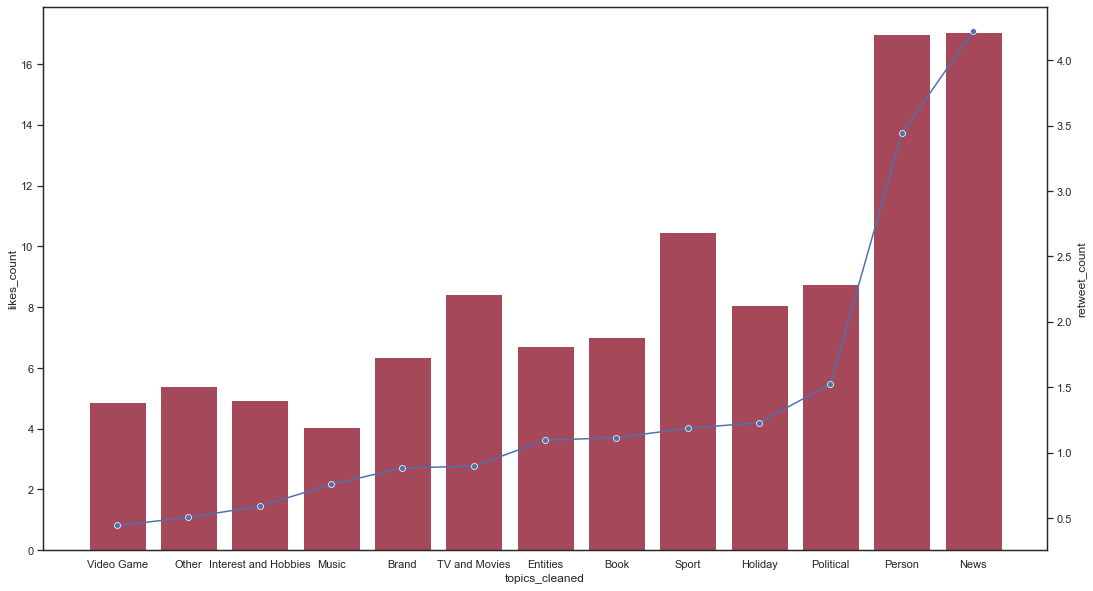

In [156]:
analysis_chart(topic_analysis_2020_ret_likes, 'retweet_count', 'topics_cleaned', 'likes_count', 18, 'Performance of each topic in retweets and likes in 2020')

#### Retweet count mean per topic during the day

In [252]:
topic_analysis_2020_day_phase = topic_analysis_2020.groupby(['day_phase','topics_cleaned']).agg(
                                                            retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
                                                            likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2020_day_phase

,day_phase,topics_cleaned,retweet_count,likes_count
0,Morning,Book,0.185185,2.537037
1,Morning,Video Game,0.244813,5.541494
2,Dawn,Book,0.288136,9.745763
3,Night,Video Game,0.352078,4.625917
4,Morning,Interest and Hobbies,0.359923,3.759491
...,...,...,...,...
60,Afternoon,News,2.149099,10.760786
61,Evening,Person,2.160386,14.354473
62,Afternoon,TV and Movies,2.344988,22.291632
63,Afternoon,Political,2.512887,10.755155


In [253]:
fig = px.bar(topic_analysis_2020_day_phase, x="day_phase", y="retweet_count", color="topics_cleaned", text="topics_cleaned", category_orders={'day_phase': day_phases}, title="Retweet count mean per topic during the day in 2020",
             color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

#### Retweet count mean per topic during the week

In [157]:
topic_analysis_2020_week_day = topic_analysis_2020.groupby(['day_of_week','topics_cleaned']).agg(
        retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
        likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2020_week_day

,day_of_week,topics_cleaned,retweet_count,likes_count
0,Sunday,Book,0.214286,3.875000
1,Monday,Book,0.233333,4.333333
2,Saturday,Book,0.301887,2.452830
3,Thursday,Other,0.305556,3.924603
4,Wednesday,Political,0.334572,1.427509
...,...,...,...,...
86,Wednesday,Book,4.177419,14.080645
87,Tuesday,Holiday,6.033970,12.575372
88,Sunday,Political,6.214612,41.890411
89,Friday,Person,6.977525,28.266274


In [158]:
# alternative to color scheme: 'color_discrete_map={'setosa': 'lightcyan', 'versicolor': 'royalblue', 'virginica': 'darkblue'}'
fig = px.bar(topic_analysis_2020_week_day, x="day_of_week", y="retweet_count", color="topics_cleaned", text="topics_cleaned", category_orders={'day_of_week': week_days}, title="Retweet count mean per topic during the week in 2020",
             color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

### Retweet count mean per topic during the year

In [242]:
topic_analysis_2020_month = topic_analysis_2020.groupby(['month','topics_cleaned']).agg(
        retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
        likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2020_month

,month,topics_cleaned,retweet_count,likes_count
0,July,Book,0.080000,1.920000
1,May,Book,0.083333,1.083333
2,February,Other,0.165563,2.258278
3,April,Book,0.192308,1.538462
4,August,Holiday,0.198198,3.810811
...,...,...,...,...
151,August,TV and Movies,3.536620,29.789399
152,March,Other,4.825843,24.511236
153,August,Political,5.010870,26.380435
154,November,News,6.229551,33.079156


In [248]:
fig = px.bar(topic_analysis_2020_month, x="month", y="retweet_count", color="topics_cleaned", text="topics_cleaned", category_orders={'month': months}, title="Retweet count mean per topic during days of the week in 2020",
             color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

#### Tweet sentiment per topic

In [ ]:
topic_analysis_2020_sentiment = topic_analysis_2020.groupby(['sentiment', 'topics_cleaned']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2020_sentiment

## Tweets performance in 2021

In [159]:
tweet_analysis_2021 = df_2021[['day_phase', 'day_of_week', 'month', 'retweet_count', 'quote_count', 'like_count', 'topics', 'sentiment']]

### Retweet count per phase of the day

In [160]:
tweet_analysis_2021_ret_day_phase = tweet_analysis_2021.groupby(['day_phase']).agg(
    day_phase_count=pd.NamedAgg(column="day_phase", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).reindex(day_phases).reset_index()
tweet_analysis_2021_ret_day_phase

,day_phase,day_phase_count,retweet_count,likes_count
0,Dawn,107774,1.099412,9.107725
1,Morning,106738,0.979492,6.745161
2,Afternoon,107631,1.486523,11.507930
3,Evening,107664,1.799079,12.740981
4,Night,107638,2.313988,14.951281


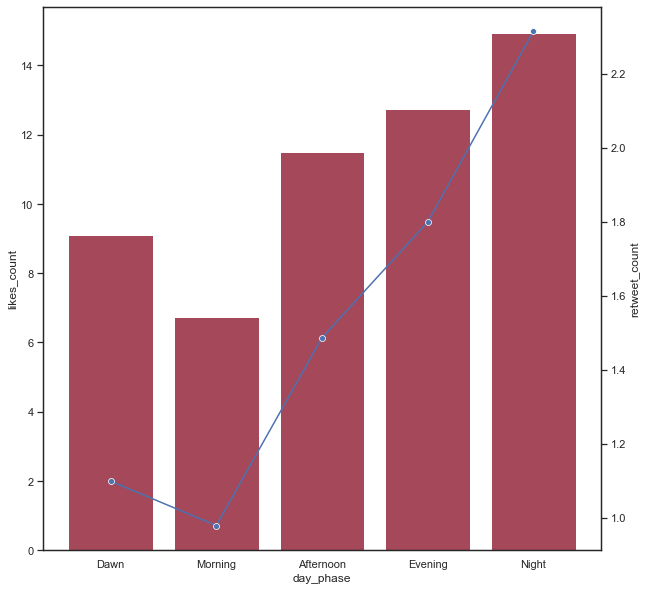

In [161]:
analysis_chart(tweet_analysis_2021_ret_day_phase, 'retweet_count', 'day_phase', 'likes_count', 10, 'Retweet count per phase of the day in 2021')

### Retweet count per day of the week

In [162]:
tweet_analysis_2021_week_day = tweet_analysis_2021.groupby(['day_of_week']).agg(
    day_of_week_count=pd.NamedAgg(column="day_of_week", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).reindex(week_days).reset_index()
tweet_analysis_2021_week_day

,day_of_week,day_of_week_count,retweet_count,likes_count
0,Monday,76477,1.192424,9.381317
1,Tuesday,76504,1.782221,11.173220
2,Wednesday,76592,2.523828,12.111382
3,Thursday,76613,1.458134,10.902993
4,Friday,78041,1.552235,14.927858
5,Saturday,76606,1.109091,8.984414
6,Sunday,76612,1.137472,9.564820


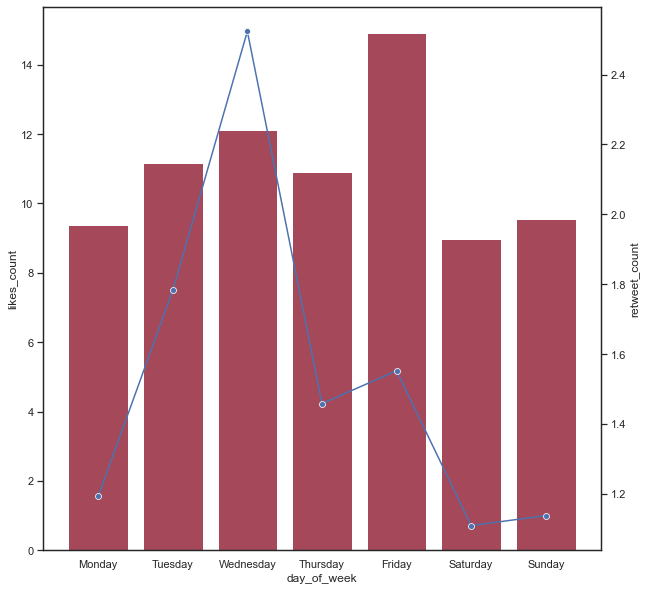

In [163]:
analysis_chart(tweet_analysis_2021_week_day, 'retweet_count', 'day_of_week', 'likes_count', 10, 'Retweet count per day of the week in 2021')

### Retweet count per month

In [164]:
tweet_analysis_2021_month = tweet_analysis_2021.groupby(['month']).agg(
    month_count=pd.NamedAgg(column="month", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).reindex(months).reset_index()
tweet_analysis_2021_month

,month,month_count,retweet_count,likes_count
0,January,45087,0.786213,6.296804
1,February,40816,1.077029,7.251127
2,March,45282,1.009076,7.791462
3,April,43805,3.129529,10.594590
4,May,45502,1.276076,14.039910
5,June,44206,1.107859,9.050943
6,July,45727,1.109563,8.451156
7,August,45934,1.914116,14.078852
8,September,44303,2.020044,12.607837
9,October,45994,2.028330,14.471627


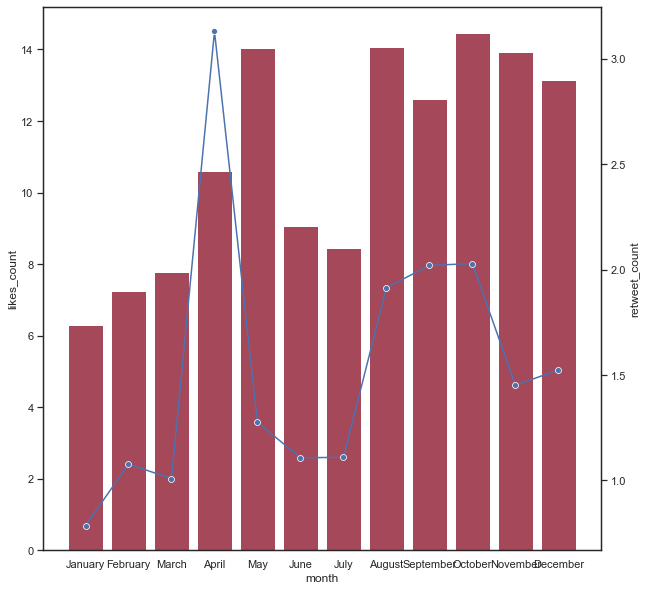

In [165]:
analysis_chart(tweet_analysis_2021_month, 'retweet_count', 'month', 'likes_count', 10, 'Retweet count per month in 2021')

### Tweets performance by sentiment

In [166]:
tweet_analysis_2021_sentiment = tweet_analysis_2021.groupby(['sentiment']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'],
                                                                              ascending=False).reset_index()
tweet_analysis_2021_sentiment

,sentiment,retweet_count,likes_count
0,Negative,2.277905,13.496328
1,Positive,1.610694,12.038044
2,Neutral,0.945472,8.054501


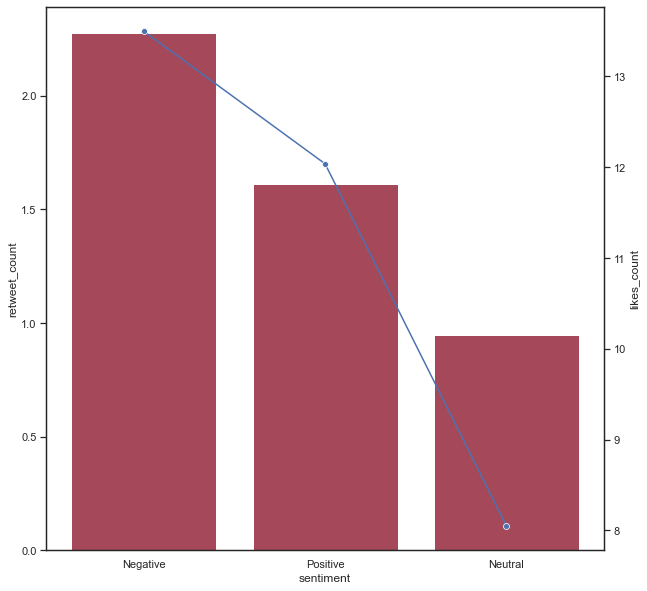

In [167]:
analysis_chart(tweet_analysis_2021_sentiment, 'likes_count', 'sentiment', 'retweet_count', 10, 'Tweets performance by sentiment in 2021')

### Tweets performance by topics

In [ ]:
topic_analysis_2021 = tweet_analysis_2021[tweet_analysis_2021['topics'] != ''].copy()
topic_analysis_2021['topics'].value_counts()

In [ ]:
topic_analysis_2021['topics_cleaned'] = topic_analysis_2021['topics'].apply(lambda topic: group_topics(topic))
topic_analysis_2021['topics_cleaned'].value_counts(normalize=True)

#### Performance of each topic in retweets and likes

In [ ]:
topic_analysis_2021_ret_likes = topic_analysis_2021.groupby(['topics_cleaned']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2021_ret_likes

In [ ]:
analysis_chart(topic_analysis_2021_ret_likes, 'retweet_count', 'topics_cleaned', 'likes_count', 18, 'Performance of each topic in retweets and likes in 2021')

#### Retweet count mean per topic during the day

In [ ]:
topic_analysis_2021_day_phase = topic_analysis_2021.groupby(['day_phase', 'topics_cleaned']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2021_day_phase

In [ ]:
fig = px.bar(topic_analysis_2021_day_phase, x="day_phase", y="retweet_count", color="topics_cleaned", text="topics_cleaned", category_orders={'day_phase': day_phases}, color_discrete_sequence=px.colors.qualitative.Dark24,
             title='Retweet count mean per topic during the day in 2021')
fig.show()

In [ ]:
#### Retweet count mean per topic during the week

In [170]:
topic_analysis_2021_week_day = topic_analysis_2021.groupby(['day_of_week','topics_cleaned']).agg(
        retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
        likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_of_week']).reset_index()
topic_analysis_2021_week_day

,day_of_week,topics_cleaned,retweet_count,likes_count
0,Friday,Book,0.591837,3.612245
1,Friday,Video Game,0.496753,8.457792
2,Friday,TV and Movies,2.792783,27.777778
3,Friday,Sport,0.913004,10.286630
4,Friday,Person,1.924023,19.250391
...,...,...,...,...
86,Wednesday,Brand,0.848840,8.089546
87,Wednesday,Book,0.200000,2.644444
88,Wednesday,TV and Movies,1.645661,13.462318
89,Wednesday,Music,0.626050,6.432773


In [171]:
fig = px.bar(topic_analysis_2021_week_day, x="day_of_week", y="retweet_count", color="topics_cleaned", text="topics_cleaned", category_orders={'day_of_week': week_days}, color_discrete_sequence=px.colors.qualitative.Dark24, title='Retweet count mean per topic during the week in 2021')
fig.show()

#### Retweet count mean per topic during the year

In [ ]:
topic_analysis_2021_month = topic_analysis_2021.groupby(['month', 'topics_cleaned']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2021_month

In [ ]:
fig = px.bar(topic_analysis_2021_month, x="month", y="retweet_count", color="topics_cleaned", text="topics_cleaned", category_orders={'month': months}, color_discrete_sequence=px.colors.qualitative.Dark24, title='Retweet count mean per topic during the year in 2021')
fig.show()

#### Tweet sentiment per topic

In [ ]:
topic_analysis_2021_sentiment = topic_analysis_2021.groupby(['sentiment', 'topics_cleaned']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=True).reset_index()
topic_analysis_2021_sentiment

## Outliers

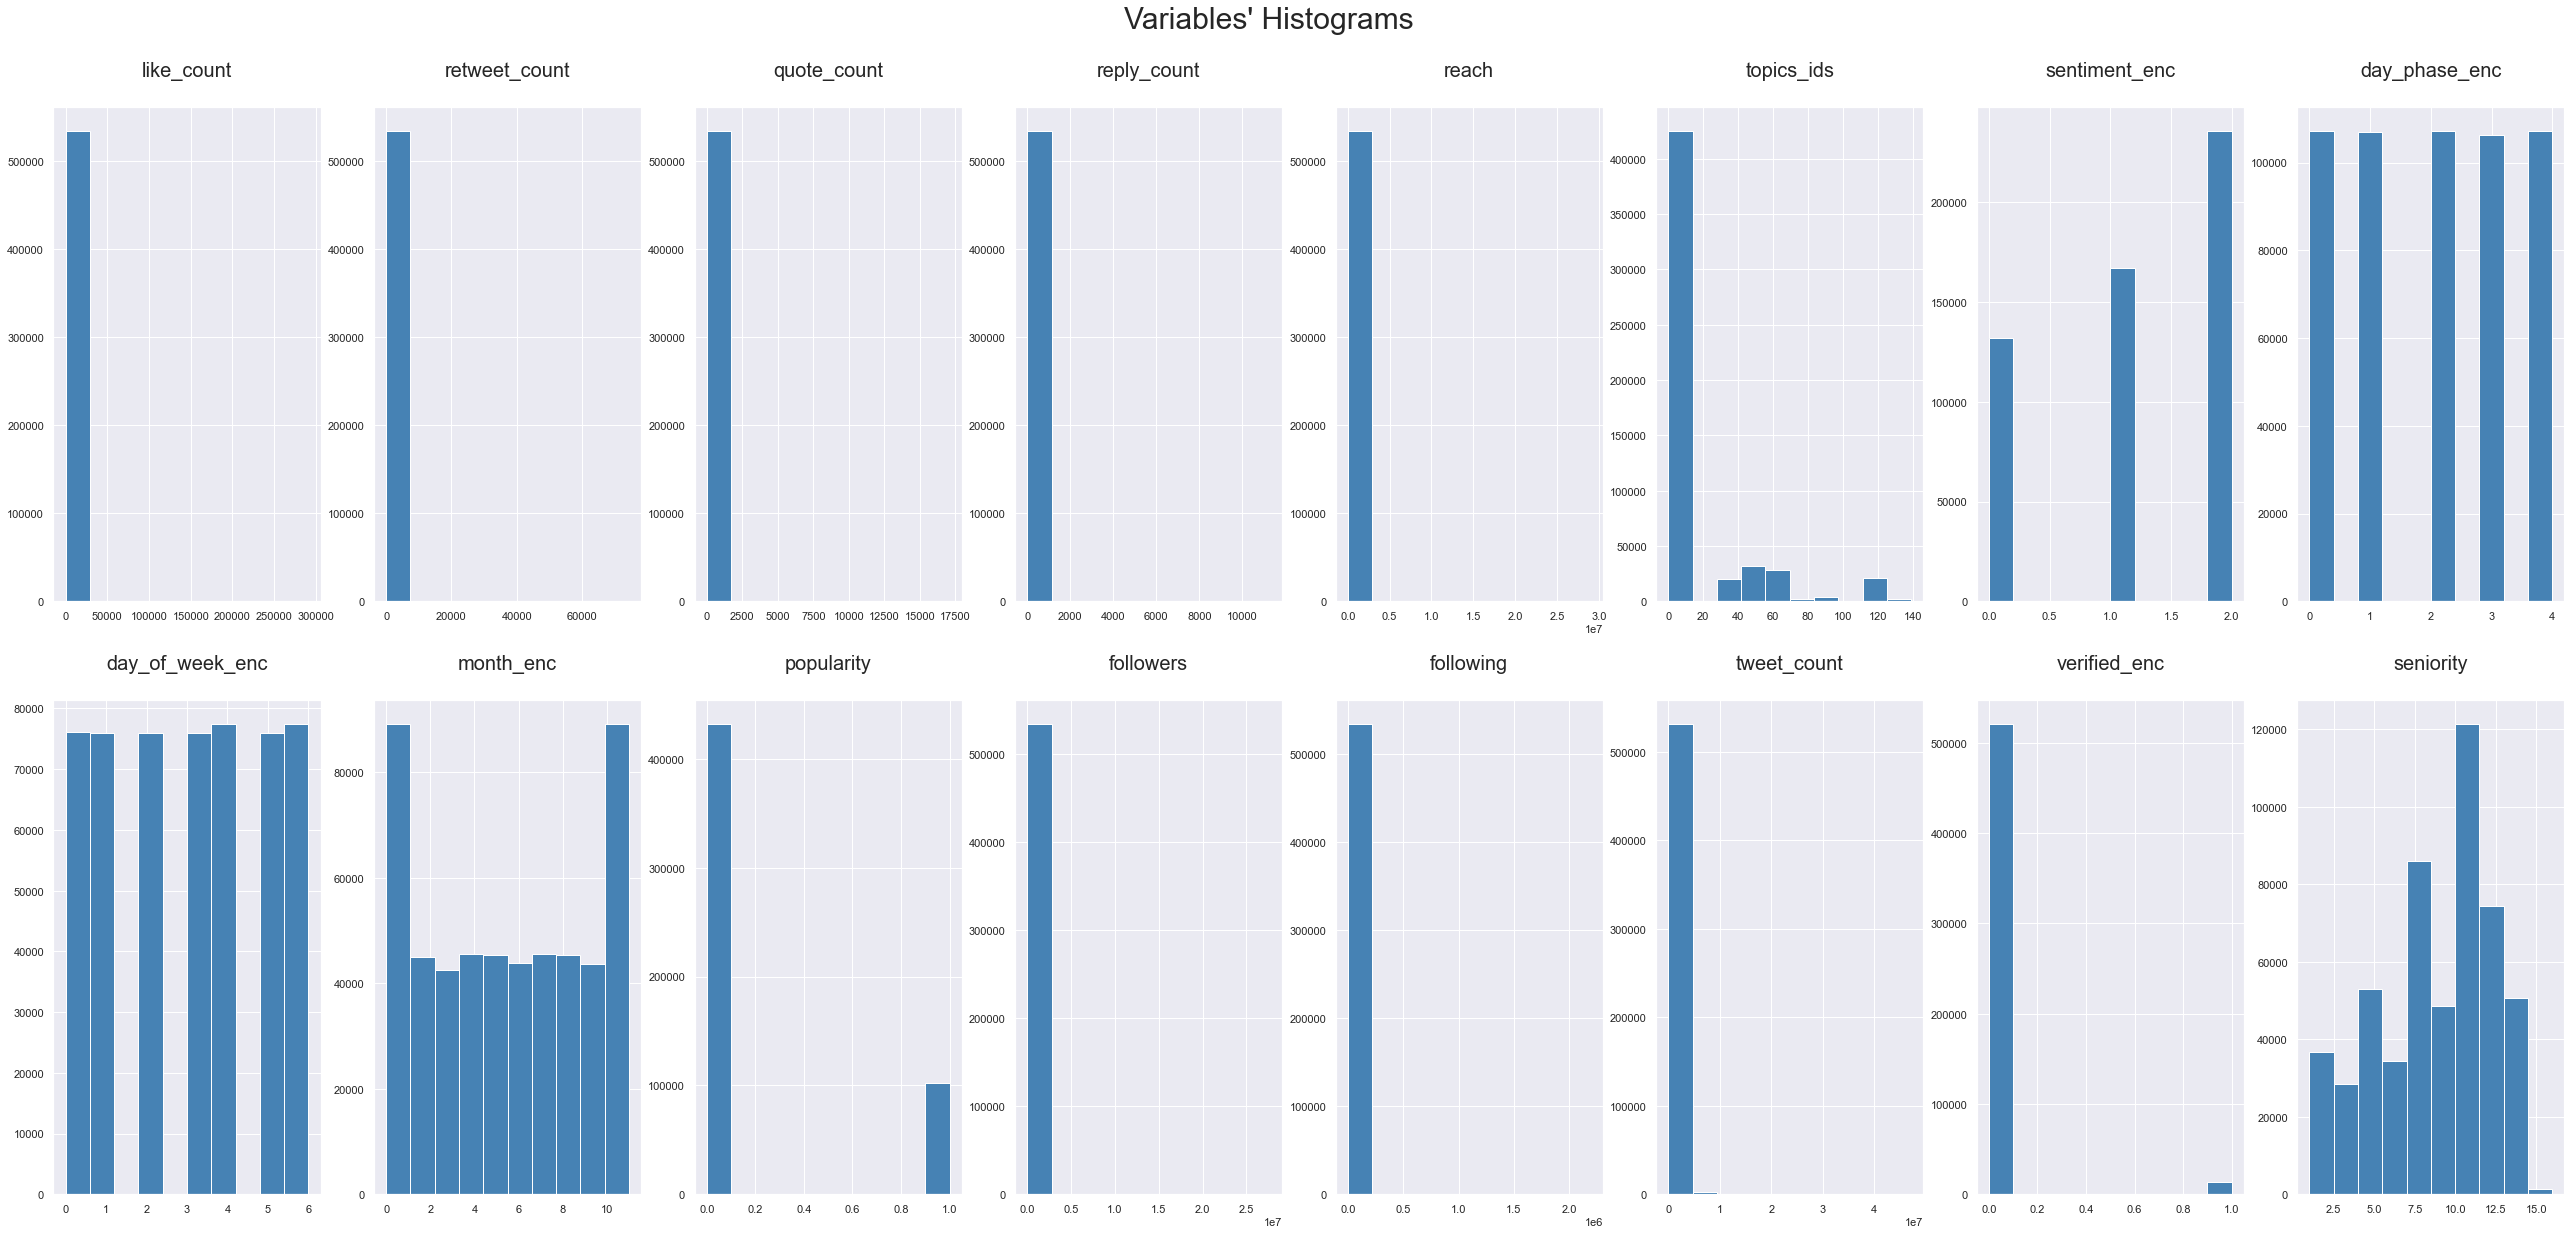

In [172]:
var_outliers = vars
sns.set()
fig, axes = plt.subplots(2, math.ceil(len(var_outliers) / 2), figsize=(45, 20))

for ax, feat in zip(axes.flatten(), var_outliers):
    ax.hist(df_2020[feat], color='steelblue')
    ax.set_title(feat, y=1.05, fontsize=20)

title = "Variables' Histograms"
plt.suptitle(title, y=0.95, fontsize=30)
plt.show()

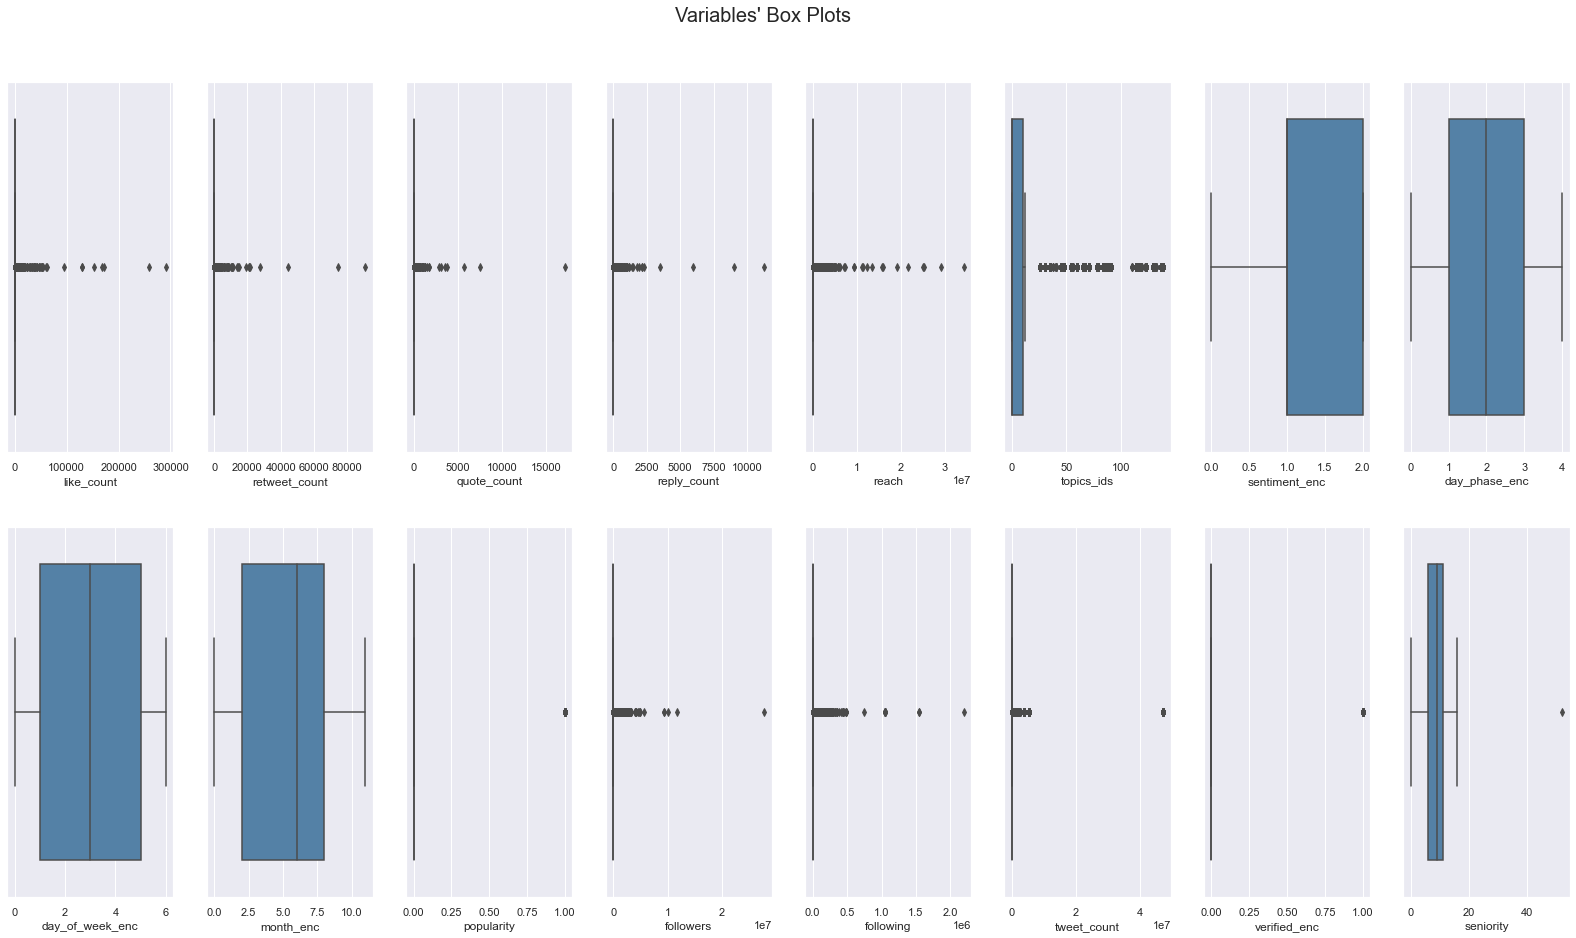

In [173]:
sns.set()
fig, axes = plt.subplots(2, math.ceil(len(var_outliers) / 2), figsize=(28, 15))

for ax, feat in zip(axes.flatten(), var_outliers):
    sns.boxplot(x=df[feat], ax=ax, color='steelblue')

title = "Variables' Box Plots"
plt.suptitle(title, y=0.95, fontsize=20)
plt.show()

# Machine Learning

### Predicting tweet popularity in 2021 using 2020 data with topics

## Data spliting

In [174]:
num_folds = 10
seed = 7
scoring = 'accuracy'
validation_size = 0.70

In [175]:
df_2020_topics = df_2020[(~df_2020['topics'].isnull()) & (df_2020['topics'] != '')]
df_2020_topics

,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,5
46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,0,1,...,Wednesday,Dawn,2020-01,1,6,4,0,0,0,4
35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,7,2,...,Wednesday,Dawn,2020-01,1,6,4,0,0,0,6
41,41,41,1212176426088181760,Disgruntled Pope Francis pulls himself free fr...,2020-01-01 00:59:15,858762062,0,0,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,9
52,52,52,1212176427845607426,My NASA engineer sister..... I would tell you ...,2020-01-01 00:59:16,1057480999943032832,11,0,0,0,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154051,154051,154051,1344765260260020224,"This might be more devastating than ""n****r na...",2020-12-31 21:59:57+00:00,206374653,1,0,0,0,...,Thursday,Night,2020-53,4,4,2,0,0,0,11
679919,679919,679919,1344765260151066624,2020 YOURE a real son of a bitch https://t.co/...,2020-12-31 21:59:57+00:00,387676464,2,1,0,0,...,Thursday,Night,2020-53,4,4,2,0,0,0,10
736687,736687,736687,1344765262147575808,Happy New Year from FreeBikes4KidzMN! Everyone...,2020-12-31 21:59:57+00:00,193418595,2,2,0,0,...,Thursday,Night,2020-53,4,4,2,0,2,0,11
803046,803046,803046,1344765266530590722,Wanna give a shoutout to whom ever invented co...,2020-12-31 21:59:58+00:00,988833535,0,0,0,0,...,Thursday,Night,2020-53,4,4,2,0,2,0,9


In [176]:
inputs = df_2020_topics[tweet_vars + users_vars]
inputs.columns

Index(['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach',
       'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc',
       'followers', 'following', 'tweet_count', 'verified_enc', 'seniority'],
      dtype='object')

In [177]:
targets = df_2020_topics['popularity']
X_train, X_validation, y_train, y_validation = train_test_split(inputs, targets, test_size=validation_size, random_state=seed, shuffle=False)

#### Partition of numeric and categorical datasets

In [178]:
X_train_num = X_train[num_vars].set_index(X_train.index)
X_train_cat = X_train[cat_vars].set_index(X_train.index)

X_val_num = X_validation[num_vars].set_index(X_validation.index)
X_val_cat = X_validation[cat_vars].set_index(X_validation.index)

## Standardization

In [179]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train.columns)

X_val_scaled = scaler.fit_transform(X_validation)
X_val_scaled = pd.DataFrame(X_val_scaled , columns = X_validation.columns)

In [180]:
scaler = StandardScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_validation.index)

## Feature Selection

### Univariate variables

In [181]:
X_train_num_scaled.var()

like_count       1.000017
retweet_count    1.000017
quote_count      1.000017
reply_count      1.000017
reach            1.000017
followers        1.000017
following        1.000017
tweet_count      1.000017
seniority        1.000017
dtype: float64

In [182]:
num_feat_to_keep = pd.DataFrame(index=X_train_num_scaled.columns)
num_feat_to_keep

""
like_count
retweet_count
quote_count
reply_count
reach
followers
following
tweet_count
seniority


### Recursive Feature Elimination - RFE

In [183]:
#no of features
nof_list = np.arange(1, 9)
high_score = 0
#Variable to store the optimum features
nof = 0
score_list = []
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled, y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe, y_train)

    score = model.score(X_val_rfe, y_validation)
    score_list.append(score)

    if score > high_score:
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Optimum number of features: 8
Score with 8 features: 0.927166


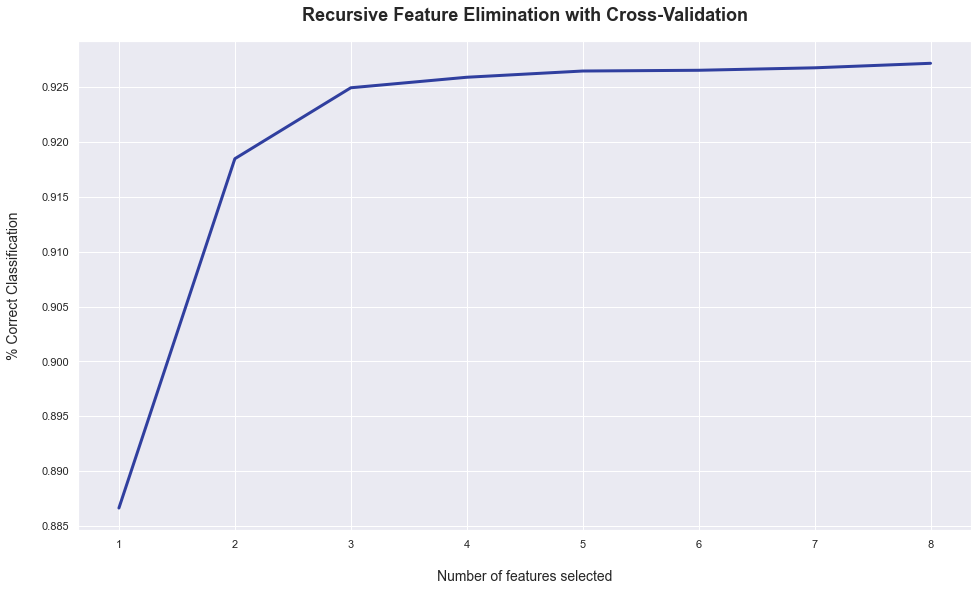

In [184]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(score_list) + 1), score_list, color='#303F9F', linewidth=3)
plt.show()

In [185]:
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X=X_train_num_scaled, y=y_train)
selected_features = pd.Series(rfe.support_, index=X_train_num_scaled.columns)
selected_features[selected_features == True]

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



like_count       True
retweet_count    True
quote_count      True
reach            True
followers        True
dtype: bool

In [186]:
num_feat_to_keep['RFE'] = 'Discard'

for var in selected_features[selected_features == True].index:
    num_feat_to_keep.loc[var, 'RFE'] = 'Keep'

### LASSO Regression

In [187]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8, 10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [188]:
reg = LassoCV()
reg.fit(X_train_num_scaled, y_train)
coef = pd.Series(reg.coef_,
                 index=X_train_num_scaled.columns)  #Check the coefficients associated with each of the variables
coef

like_count       0.000000
retweet_count    0.000000
quote_count      0.013782
reply_count      0.002309
reach            0.016562
followers        0.000000
following        0.012546
tweet_count      0.000000
seniority       -0.000000
dtype: float64

In [189]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 5 variables


In [190]:
coef.sort_values()

like_count       0.000000
retweet_count    0.000000
followers        0.000000
tweet_count      0.000000
seniority       -0.000000
reply_count      0.002309
following        0.012546
quote_count      0.013782
reach            0.016562
dtype: float64

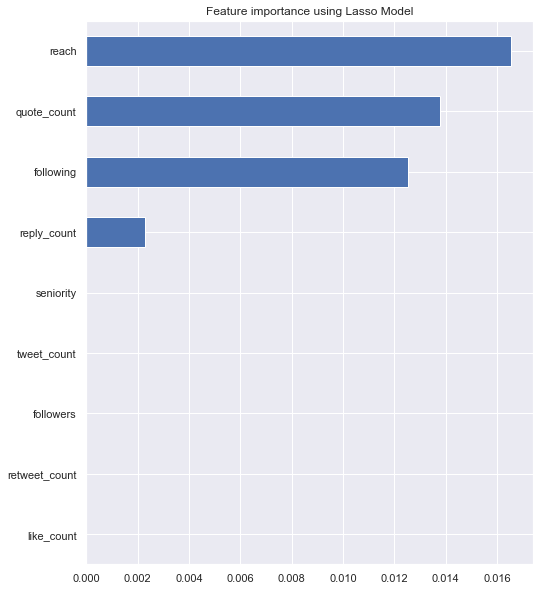

In [191]:
plot_importance(coef,'Lasso')

### Chi-square

In [192]:
chi_scores = chi2(X_train[cat_vars], y_train)
chi_scores

(array([  29.12438373, 2159.55202407,    2.4548875 ,   13.54201155,
          14.39477056]),
 array([6.78772914e-08, 0.00000000e+00, 1.17159562e-01, 2.33282231e-04,
        1.48213338e-04]))

<AxesSubplot:>

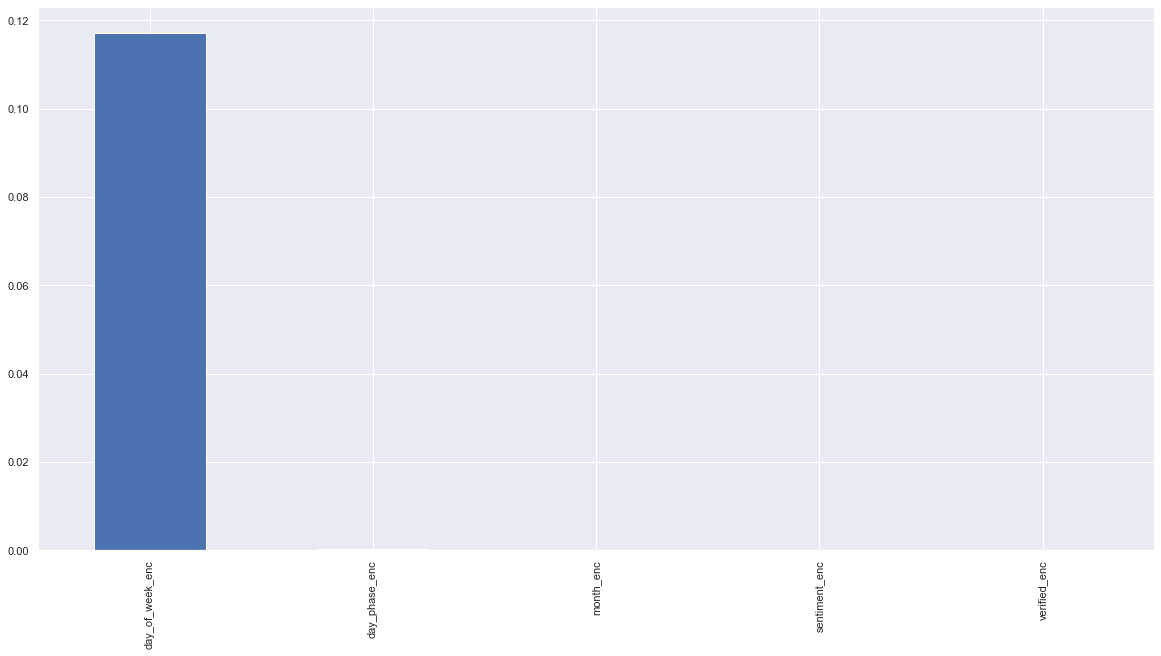

In [193]:
p_values = pd.Series(chi_scores[1], index=cat_vars)
p_values.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(20, 10))
p_values.plot.bar()

In [194]:
chi2_features = SelectKBest(chi2, k=5)
best_features = chi2_features.fit_transform(X_train[cat_vars], y_train)
cols = chi2_features.get_support(indices=True)
cols

array([0, 1, 2, 3, 4])

In [195]:
features_to_keep = X_train[cat_vars].iloc[:, cols]
features_to_keep.columns

Index(['sentiment_enc', 'verified_enc', 'day_of_week_enc', 'day_phase_enc',
       'month_enc'],
      dtype='object')

In [196]:
features_to_keep

,sentiment_enc,verified_enc,day_of_week_enc,day_phase_enc,month_enc
44,2,0,6,1,4
46,0,0,6,1,4
35,0,0,6,1,4
41,2,0,6,1,4
52,2,0,6,1,4
...,...,...,...,...,...
420599,2,0,2,0,0
183184,2,0,2,0,0
54770,2,0,2,0,0
418613,0,0,2,0,0


In [197]:
cat_feat_to_keep = pd.DataFrame(index=cat_vars)
cat_feat_to_keep

""
sentiment_enc
verified_enc
day_of_week_enc
day_phase_enc
month_enc


In [198]:
cat_feat_to_keep['Chi square'] = 'Discard'
cat_feat_to_keep.loc[['sentiment_enc', 'verified_enc', 'day_phase_enc', 'month_enc'],'Chi square']='Keep'

### Ridge regression

In [199]:
ridge = RidgeCV()
ridge.fit(X_train_num_scaled, y_train)
print("Best score using built-in RidgeCV: %f" % ridge.score(X_train_num_scaled, y_train))

Best score using built-in RidgeCV: 0.020590


In [200]:
coef_ridge = pd.Series(ridge.coef_, index=X_train_num_scaled.columns)
coef_ridge.sort_values().head()

seniority       -0.016660
like_count      -0.014145
retweet_count    0.006109
followers        0.007367
tweet_count      0.007875
dtype: float64

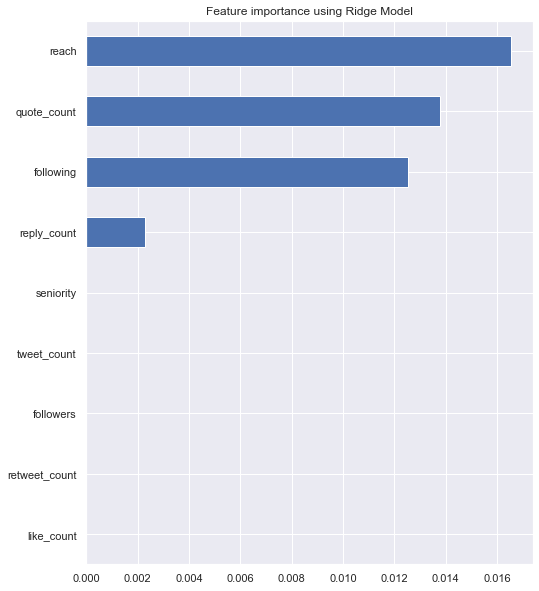

In [201]:
plot_importance(coef, 'Ridge')

In [202]:
num_feat_to_keep['Ridge Regression'] = 'Discard'

for var in abs(coef_ridge).nlargest(5).index:
  num_feat_to_keep.loc[var,'Ridge Regression'] = 'Keep'

### ANOVA

In [203]:
# Select features with best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k='all')
X_kbest = fvalue_selector.fit_transform(X_train_num_scaled, y_train)
print('Original number of features:', X_train_num_scaled.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 9
Reduced number of features: 9


In [204]:
cols = fvalue_selector.get_support(indices=True)
features_to_keep = X_train_num_scaled.iloc[:, cols]
features_to_keep.columns

Index(['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach',
       'followers', 'following', 'tweet_count', 'seniority'],
      dtype='object')

<AxesSubplot:>

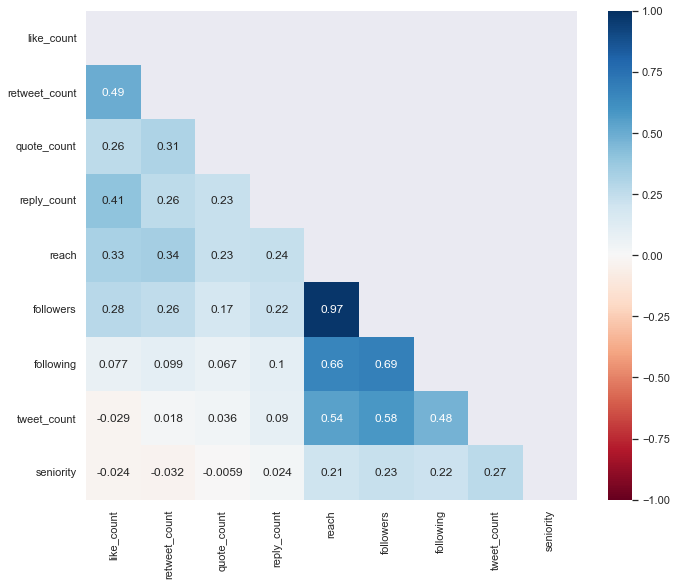

In [205]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(X_train_num_scaled.corr(method="spearman"), dtype=bool))
sns.heatmap(X_train_num_scaled.corr(method="spearman"), annot=True, mask=mask, vmin=-1, vmax=1, cmap='RdBu')

In [206]:
num_feat_to_keep['ANOVA'] = 'Discard'

for var in features_to_keep.columns:
    num_feat_to_keep.loc[var, 'ANOVA'] = 'Keep'

### Tree-Based Classifiers

[0.07497499 0.65070375 0.16574138 0.02563926 0.03764855 0.02695186
 0.00827158 0.00555213 0.0045165 ]


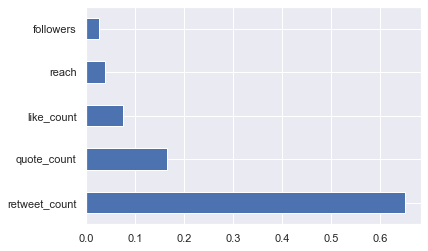

In [207]:
#TREE BASED CLASSIFIERS
model = ExtraTreesClassifier()
model.fit(X_train_num_scaled, y_train)
print(model.feature_importances_)  #use inbuilt class feature_importances of tree based classifiers

feat_importances = pd.Series(model.feature_importances_, index=X_train_num_scaled.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [208]:
feat_importances.nlargest(5).index

Index(['retweet_count', 'quote_count', 'like_count', 'reach', 'followers'], dtype='object')

In [209]:
num_feat_to_keep['Tree Based Classifiers'] = 'Discard'

for var in feat_importances.nlargest(5).index:
    num_feat_to_keep.loc[var, 'Tree Based Classifiers'] = 'Keep'

### ENTROPY / GINI IMPORTANCE

In [210]:
#ENTROPY / GINI IMPORTANCE
gini_importance = DecisionTreeClassifier().fit(X_train_num_scaled, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train_num_scaled, y_train).feature_importances_

<AxesSubplot:xlabel='Value', ylabel='Col'>

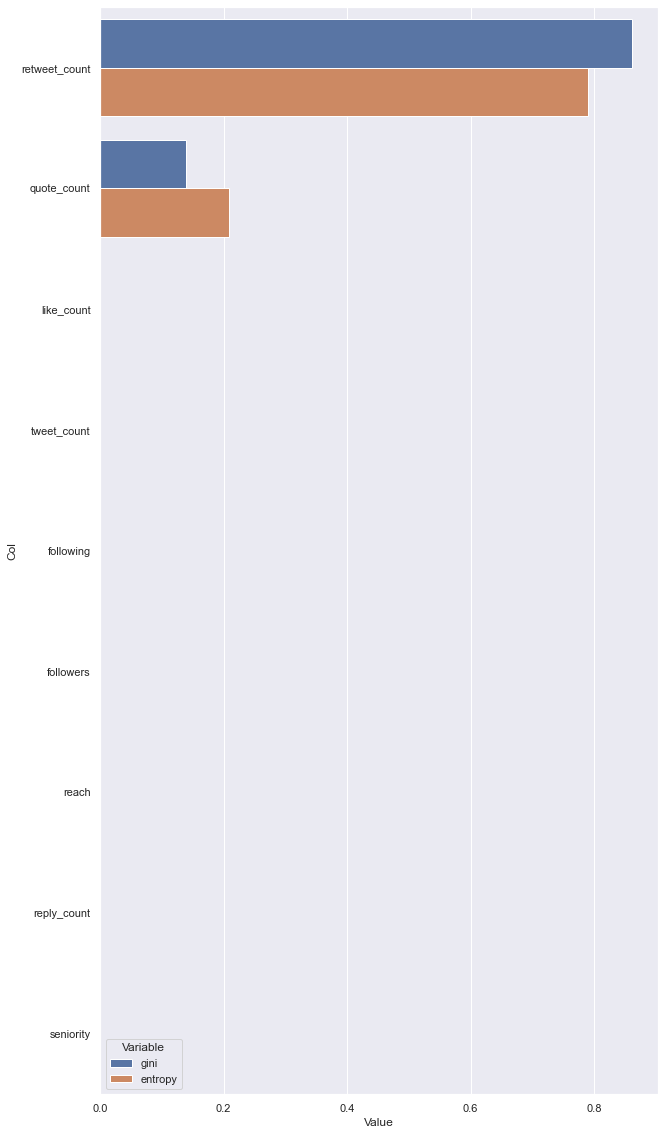

In [211]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns=['gini', 'entropy'])
zippy['col'] = X_train_num_scaled.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending=False, inplace=True)

plt.figure(figsize=(10, 20))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [212]:
zippy = zippy.set_index('col')
num_feat_to_keep['Gini Importance'] = 'Discard'

for var in zippy['gini'].nlargest(5).index:
    num_feat_to_keep.loc[var, 'Gini Importance'] = 'Keep'

### Forward Selection

In [213]:
sys.modules['sklearn.externals.joblib'] = joblib
sfs = Sfs(LogisticRegression(),
          k_features=5,
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)
sfs.fit(X_train_num_scaled, y_train)
sfs.k_feature_names_

('like_count', 'retweet_count', 'quote_count', 'reach', 'followers')

In [214]:
num_feat_to_keep['Sequential Feature Selection'] = 'Discard'

for var in sfs.k_feature_names_:
    num_feat_to_keep.loc[var, 'Sequential Feature Selection'] = 'Keep'

### Final Selected Variables

In [215]:
num_feat_to_keep['Discard Nr'] = num_feat_to_keep.apply(lambda x: x.str.findall('Discard').str.len()).sum(
    axis=1).astype(int)
num_feat_to_keep

,RFE,Ridge Regression,ANOVA,Tree Based Classifiers,Gini Importance,Sequential Feature Selection,Discard Nr
like_count,Keep,Discard,Keep,Keep,Keep,Keep,1
retweet_count,Keep,Discard,Keep,Keep,Keep,Keep,1
quote_count,Keep,Keep,Keep,Keep,Keep,Keep,0
reply_count,Discard,Keep,Keep,Discard,Keep,Discard,3
reach,Keep,Keep,Keep,Keep,Keep,Keep,0
followers,Keep,Discard,Keep,Keep,Discard,Keep,2
following,Discard,Keep,Keep,Discard,Discard,Discard,4
tweet_count,Discard,Discard,Keep,Discard,Discard,Discard,5
seniority,Discard,Keep,Keep,Discard,Discard,Discard,4


In [216]:
cat_feat_to_keep

,Chi square
sentiment_enc,Keep
verified_enc,Keep
day_of_week_enc,Discard
day_phase_enc,Keep
month_enc,Keep


In [217]:
variables_to_keep = ['like_count', 'reply_count', 'reach', 'followers', 'month_enc', 'verified_enc', 'day_phase_enc']

In [218]:
X_train_scaled = X_train_scaled[variables_to_keep]
X_val_scaled = X_val_scaled[variables_to_keep]
df_2020['popularity'].value_counts(normalize=True)

0    0.808243
1    0.191757
Name: popularity, dtype: float64

## Balacing the dataset

#### Random Under Sampling method

In [219]:
# summarize class distribution
print("Before under sampling: ", Counter(y_train))
# define undersampling strategy
under_sample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_under, y_train_under = under_sample.fit_resample(X_train_scaled, y_train)
# summarize class distribution
print("After under sampling: ", Counter(y_train_under))

Before under sampling:  Counter({0: 45828, 1: 11448})
After under sampling:  Counter({0: 11448, 1: 11448})


#### SMOTE method

In [220]:
# summarize class distribution
print("Before over sampling: ", Counter(y_train))
over_sample = SMOTE(random_state=seed)
X_train_over, y_train_over = over_sample.fit_resample(X_train_scaled, y_train)
# summarize class distribution
print("After over sampling: ", Counter(y_train_over))

Before over sampling:  Counter({0: 45828, 1: 11448})
After over sampling:  Counter({0: 45828, 1: 45828})


## Models

### Defining the algorithms

In [221]:
models = [('LR', LogisticRegression(solver='lbfgs')), ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB())]
          #('SVM', SVC(gamma='scale'))]

In [222]:
def algorithm_comparison(title):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.figure(figsize=(16, 9))
    plt.show()

#### Algorithm benchmark with Under Sampling

In [223]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train_under, y_train_under, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.646450 (0.214726)
LDA: 0.081907 (0.089547)
KNN: 0.578507 (0.180887)
CART: 0.589868 (0.161101)
NB: 0.622626 (0.342552)


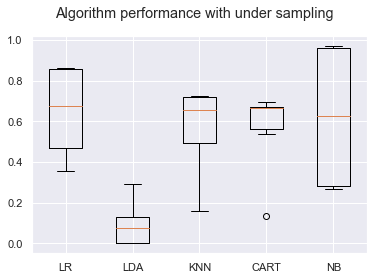

<Figure size 1152x648 with 0 Axes>

In [224]:
algorithm_comparison('Algorithm performance with under sampling')

#### Algorithm benchmark with Over Sampling

In [225]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.702838 (0.141598)
LDA: 0.271565 (0.114977)
KNN: 0.747755 (0.049416)
CART: 0.772304 (0.055762)
NB: 0.615789 (0.264983)


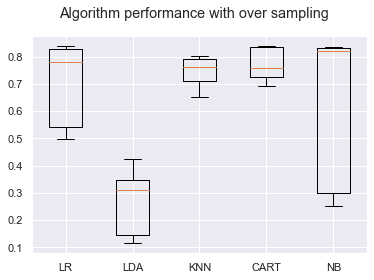

<Figure size 1152x648 with 0 Axes>

In [226]:
algorithm_comparison('Algorithm performance with over sampling')

### Ensemble methods

#### Algorithm benchmark with Under Sampling

In [227]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_under, y_train_under, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.621616 (0.176486)
GBM: 0.615633 (0.175001)
RFC: 0.601050 (0.160219)
ET: 0.579823 (0.159675)


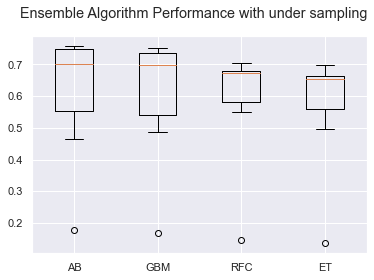

<Figure size 1152x648 with 0 Axes>

In [228]:
algorithm_comparison('Ensemble Algorithm Performance with under sampling')

#### Algorithm benchmark with Over Sampling

In [229]:
ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.721831 (0.036409)
GBM: 0.737258 (0.041929)
RFC: 0.776668 (0.061669)
ET: 0.763040 (0.053038)


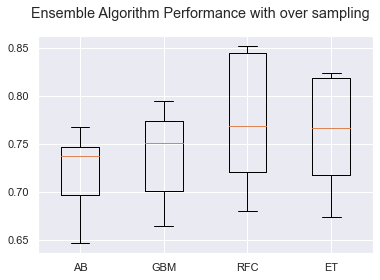

<Figure size 1152x648 with 0 Axes>

In [230]:
algorithm_comparison('Ensemble Algorithm Performance with over sampling')

#### Tuning the best ensemble model (RFC)

In [231]:
# param_grid = dict(n_estimators=numpy.array([50, 100, 150, 200, 250, 300, 350, 400]))
#param_grid = dict(n_estimators=numpy.array([50, 200, 300, 400]))
#model = RandomForestClassifier(random_state=seed)
#kfold = KFold(n_splits=num_folds)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
#grid_result = grid.fit(X_train_over, y_train_over)

#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#### Tuning Gradient Boosting Classifier

In [232]:
param_grid = dict(n_estimators=numpy.array([20, 30, 40, 50, 60, 70, 80]))
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.869788 using {'n_estimators': 80}
0.865685 (0.007371) with: {'n_estimators': 20}
0.867588 (0.006911) with: {'n_estimators': 30}
0.868077 (0.006896) with: {'n_estimators': 40}
0.868758 (0.006573) with: {'n_estimators': 50}
0.869229 (0.006666) with: {'n_estimators': 60}
0.869631 (0.006891) with: {'n_estimators': 70}
0.869788 (0.006355) with: {'n_estimators': 80}


In [233]:
param_grid2 = {'max_depth':[9], 'min_samples_split':range(1000,1601,200)}
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, n_estimators=40, max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid2, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

#0.857884 : acc
# 0.850

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.863621 using {'max_depth': 9, 'min_samples_split': 1000}
0.863621 (0.007518) with: {'max_depth': 9, 'min_samples_split': 1000}
0.863272 (0.007071) with: {'max_depth': 9, 'min_samples_split': 1200}
0.862908 (0.007474) with: {'max_depth': 9, 'min_samples_split': 1400}
0.863370 (0.006842) with: {'max_depth': 9, 'min_samples_split': 1600}


In [234]:
param_grid3 = {'min_samples_split':range(1000,1600,200), 'min_samples_leaf':range(30,71,10)}
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, n_estimators=40, max_depth=9, max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid3, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.863068 using {'min_samples_leaf': 40, 'min_samples_split': 1400}
0.863008 (0.007501) with: {'min_samples_leaf': 30, 'min_samples_split': 1000}
0.862933 (0.007172) with: {'min_samples_leaf': 30, 'min_samples_split': 1200}
0.863056 (0.007733) with: {'min_samples_leaf': 30, 'min_samples_split': 1400}
0.862983 (0.007285) with: {'min_samples_leaf': 40, 'min_samples_split': 1000}
0.863034 (0.007139) with: {'min_samples_leaf': 40, 'min_samples_split': 1200}
0.863068 (0.007466) with: {'min_samples_leaf': 40, 'min_samples_split': 1400}
0.862971 (0.007253) with: {'min_samples_leaf': 50, 'min_samples_split': 1000}
0.862251 (0.007356) with: {'min_samples_leaf': 50, 'min_samples_split': 1200}
0.862741 (0.007244) with: {'min_samples_leaf': 50, 'min_samples_split': 1400}
0.862815 (0.007295) with: {'min_samples_leaf': 60, 'min_samples_split': 1000}
0.862485 (0.007453) with: {'min_samples_leaf': 60, 'min_samples_split': 1200}
0.862788 (0.007449) with: {'min_samples_leaf': 60, 'min_samples_split

In [235]:
param_grid4 = {'max_features':range(7,20,2)}
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.8, random_state=10)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid4, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


60 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "/Users/migueloliveira/opt/anaconda3/envs/pythonP

Best: 0.864883 using {'max_features': 7}
0.864883 (0.007275) with: {'max_features': 7}
nan (nan) with: {'max_features': 9}
nan (nan) with: {'max_features': 11}
nan (nan) with: {'max_features': 13}
nan (nan) with: {'max_features': 15}
nan (nan) with: {'max_features': 17}
nan (nan) with: {'max_features': 19}


In [236]:
param_grid5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.8, max_features=7, random_state=seed)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid5, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.865577 using {'subsample': 0.8}
0.865066 (0.007983) with: {'subsample': 0.6}
0.865264 (0.007367) with: {'subsample': 0.7}
0.865130 (0.007357) with: {'subsample': 0.75}
0.865577 (0.007680) with: {'subsample': 0.8}
0.865106 (0.007491) with: {'subsample': 0.85}
0.865394 (0.007697) with: {'subsample': 0.9}


#### The final values were:

min_samples_split: 1200
min_samples_leaf: 40
max_depth: 9
max_features: 7
subsample: 0.85

New test with half the learning rate and double the nº of trees (estimators)

In [237]:
model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=80, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.18204673505578128
[[   214 109274]
 [    43  24116]]
              precision    recall  f1-score   support

           0       0.83      0.00      0.00    109488
           1       0.18      1.00      0.31     24159

    accuracy                           0.18    133647
   macro avg       0.51      0.50      0.16    133647
weighted avg       0.71      0.18      0.06    133647



In [238]:
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=400, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.1809767521904719
[[    34 109454]
 [     6  24153]]
              precision    recall  f1-score   support

           0       0.85      0.00      0.00    109488
           1       0.18      1.00      0.31     24159

    accuracy                           0.18    133647
   macro avg       0.52      0.50      0.15    133647
weighted avg       0.73      0.18      0.06    133647



In [239]:
model = GradientBoostingClassifier(learning_rate=0.005, n_estimators=800, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.18089444581621736
[[    22 109466]
 [     5  24154]]
              precision    recall  f1-score   support

           0       0.81      0.00      0.00    109488
           1       0.18      1.00      0.31     24159

    accuracy                           0.18    133647
   macro avg       0.50      0.50      0.15    133647
weighted avg       0.70      0.18      0.06    133647



In [240]:
def run_tuned_random_forest(x_train, x_test, y_train, y_test):
    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    joblib.dump(model, '../../data/models/popularity.joblib')

In [241]:
run_tuned_random_forest(X_train_over, X_val_scaled, y_train_over, y_validation)

0.18076724505600575
[[     0 109488]
 [     0  24159]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    109488
           1       0.18      1.00      0.31     24159

    accuracy                           0.18    133647
   macro avg       0.09      0.50      0.15    133647
weighted avg       0.03      0.18      0.06    133647



/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



FileNotFoundError: [Errno 2] No such file or directory: '../../data/models/popularity.joblib'

## Testing the created model to predict 2021 tweets popularity

In [ ]:
test_2021 = df_2021[variables_to_keep]
target = df_2021['popularity']

In [ ]:
popularity_model = joblib.load('../../data/models/popularity.joblib')
predictions = popularity_model.predict(test_2021)
print(accuracy_score(target, predictions))
print(confusion_matrix(target, predictions))
print(classification_report(target, predictions))

In [ ]:
X_train_over['']